In [179]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

In [2]:
data = pd.read_csv("UCF-crime-frames-descriptions-partitions.csv")

In [7]:
video_name = [f.split("_")[0] for f in data["frame"]]

In [9]:
data["vn"] = video_name

In [12]:
labels = {"Normal": 0,
          "Abuse": 1,
          "Arrest": 2,
          "Arson": 3,
          "Burglary": 4,
          "Explosion": 5,
          "Fighting": 6,
          "RoadAccidents": 7,
          "Shooting": 8,
          "Vandalism": 9
         }

In [320]:
def evaluate(data, model, batch_size):
    with torch.no_grad():
        d_pred = torch.zeros([len(data), 10])
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            batch = batch.to(device)
            pred = model(batch)
            d_pred[i:i+batch_size] = pred 
    return d_pred

def get_acc(pred, target, return_sum=False):
    s = (torch.argmax(pred, dim=1).round() == target).sum()
    if (return_sum == True):
        return s
    return s/len(pred)

def get_data(df):
    X = np.zeros((len(df), 768))
    path = "d:/data/UCF-crime/Anomaly-Videos-qformer-features"
    c = 0
    for _, f in df.iterrows():
        directory = f["directory"][:-7] 
        X[c] = np.load(f"{path}/{directory}/{f['frame']}.npy")
        c += 1
    X = torch.tensor(X, dtype=torch.float32)
    y = list(df["class"])
    y = [labels[lbl] for lbl in y]
    y = torch.tensor(y, dtype=torch.float32)
    return X, y

def plot_results(y, pred):
    CLASS_LABELS = ["normal", 
                    "Abuse",
                    "Arrest",
                    "Arson",
                    "Burglary",
                    "Explosion",
                    "Fighting",
                    "RoadAccidents",
                    "Shooting",
                    "Vandalism"]
    plt.figure(figsize = (12,3))
    plt.plot(y)
    for i in range(10):
        plt.plot(pred[:,i].numpy(), label=CLASS_LABELS[i])
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

def show_frames(video, n=10):
    path = "d:/data/UCF-crime/Anomaly-Videos-frames"
    f, axarr = plt.subplots(1, n,  figsize=(15, 2)) 
    sk = len(video) // n
    for i in range(0, n):
        d = list(video["directory"])[i*sk]    
        im = imread(f"{path}/{d}/{list(video['frame'])[i*sk]}")
        axarr[i].imshow(im)
        axarr[i].title.set_text(f"Frame {i*sk}")
        axarr[i].axis('off')
    plt.show()

In [23]:
model = nn.Sequential(
    nn.Linear(768, 256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

In [24]:
model.load_state_dict(torch.load("model_image_qformer_features.pt"))

<All keys matched successfully>

In [36]:
final = nn.Sequential(model, torch.nn.Softmax(dim = 1))

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
final.to(device)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
  (1): Softmax(dim=1)
)

In [337]:
video = data.loc[data["vn"] == "Vandalism046"]
print(video["partition"].head(1))

145556    test
Name: partition, dtype: object


In [338]:
video_feat, y = get_data(video)

In [339]:
batch_size = 64
pred = evaluate(video_feat, final, batch_size)

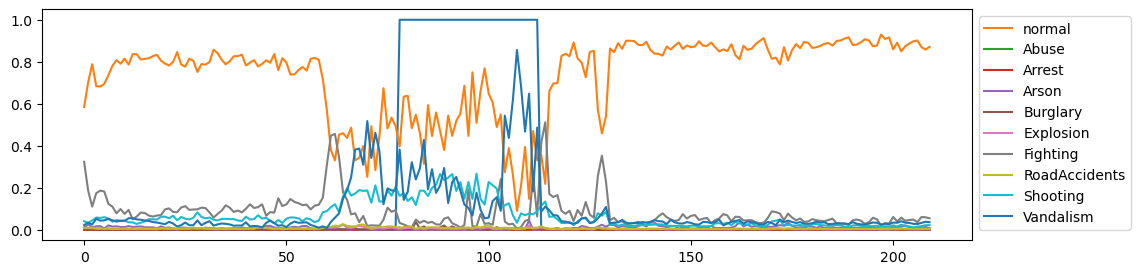

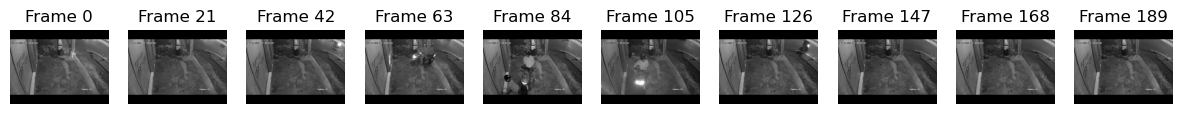

In [341]:
plot_results(y/9, pred)
show_frames(video, n=10)